In [1]:
import os
import time
import refl1d
from refl1d.names import *
from bumps import dream

import numpy as np
import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

In [12]:
sys.path.insert(0, os.path.expanduser('~/git/refl1d_analysis/notebooks'))
import plot_utils

## Accumulator class

In [3]:
class Accumulator(object):
    def __init__(self, name='', z_min=-10, z_max=450, z_step=2.0, is_magnetic=True):
        self.z = np.arange(z_min, z_max, z_step)
        self.z_mid = [(self.z[i+1]+self.z[i])/2.0 for i in range(len(self.z)-1)]
        self.summed = np.zeros(len(self.z)-1)
        self.sq_summed = np.zeros(len(self.z)-1)
        self.m_summed = np.zeros(len(self.z)-1)
        self.m_sq_summed = np.zeros(len(self.z)-1)
        self.counts = np.zeros(len(self.z)-1)
        self.z_step = z_step
        self.name = name
        self.is_magnetic = is_magnetic

    def add(self, z, rho, rhoM):
        """ Add a model to the average """
        if rhoM is None:
            self.is_magnetic = False

        z_ = np.asarray(z)
        rho_ = np.asarray(rho[:-1])
        r_out = refl1d.rebin.rebin(z_, rho_, self.z)

        # Compute the average step size so we can normalize after rebinning
        average_step = np.asarray([z[i+1]-z[i] for i in range(0, len(z)-2, 2) if z[i]>0]).mean()
        r_out = r_out * average_step / self.z_step

        self.summed += r_out
        self.sq_summed += r_out * r_out

        if self.is_magnetic:
            rhoM_ = np.asarray(rhoM[:-1])
            rM_out = refl1d.rebin.rebin(z_, rhoM_, self.z)
            rM_out = rM_out * average_step / self.z_step
            self.m_summed += rM_out
            self.m_sq_summed += rM_out * rM_out
        _counts = [ 1*(z>z_[0] and z<z_[-1]) for z in self.z[:-1] ]
        self.counts += _counts

    def mean(self):
        _counts = np.asarray([ 1 if c==0 else c for c in self.counts ])
        avg = self.summed / _counts
        sq_avg = self.sq_summed / _counts
        sig = np.sqrt(sq_avg - avg*avg)

        return self.z_mid, avg, sig

    def mean_magnetism(self):
        if not self.is_magnetic:
            return self.z_mid, np.zeros(len(self.z_mid)), np.zeros(len(self.z_mid))

        _counts = np.asarray([ 1 if c==0 else c for c in self.counts ])
        avg = self.m_summed / _counts
        sq_avg = self.m_sq_summed / _counts
        sig = np.sqrt(sq_avg - avg*avg)

        return self.z_mid, avg, sig

## Function to load MC data and compute the SLD profile with uncertainties
Loading can be very slow, consider using trim=True

In [4]:
def load_bumps(file_path, problem, trim=False, state=None, z_max=450.0):
    """
        Use bumps to load MC
    """
    model_list = [problem]
    if hasattr(problem, '_models'):
        model_list = problem._models

    acc = [Accumulator(m.fitness.name,z_max=z_max) for m in model_list]
    
    t0 = time.time()
    if state is None:
        state = dream.state.load_state(file_path)
    state.mark_outliers()

    # If we have a population, only pick 1000 of them
    if trim and state.draws>1000:
        print("Too many points: pruning down to 1000")
        portion = 1000.0 / state.draws
        drawn = state.draw(portion=portion)

    print("MC file read: %s sec" % (time.time()-t0))
    pts = np.asarray(drawn.points)

    for i, p in enumerate(pts):
        problem.setp(p)
        # Loop over models (Experiments)
        for j, model in enumerate(model_list):
            if model.fitness.ismagnetic:
                z, r, _, rM, _ = model.fitness.magnetic_smooth_profile()
                acc[j].add(z, r, rM)
            else:
                z, r, _ = model.fitness.smooth_profile()
                acc[j].add(z, r, None)

    print("Done %s sec" % (time.time()-t0))
    return acc

In [5]:
#file_path = os.path.expanduser('~/git/refl1d_analysis/playground/matfit/model152both')
file_path = '/SNS/users/m2d/reflectivity_fits/322092/__model'

# Load the model that was used for fitting
code = open(file_path+'.py', 'r')
exec code

state = dream.state.load_state(file_path)
acc_data = load_bumps(file_path, problem, state=state, trim=True, z_max=550.)

Too many points: pruning down to 1000
MC file read: 0.00925707817078 sec
Done 5.35937404633 sec


In [6]:
plot_data = []
data_names = []

for i, _acc in enumerate(acc_data):
    z, sld, dsld = _acc.mean()
    z, msld, dmsld = _acc.mean_magnetism()
    plot_data.extend([[z, sld, dsld], [z, msld, dmsld]])
    data_names.extend(['SLD [%s] %s' % (i, _acc.name), 'mSLD [%s] %s' % (i, _acc.name)])

plot_utils.plot1d(plot_data, data_names)

## Load the MC results to look at parameter distributions

In [7]:
file_path = '/SNS/users/m2d/reflectivity_fits/322092/__model'
#file_path = os.path.expanduser('~/git/refl1d_analysis/playground/matfit/model152both')
state = dream.state.load_state(file_path)
state.mark_outliers()
drawn = state.draw()
pts = np.asarray(drawn.points)

## Load the model used
We will use it to get the reflectivity curve and the names of the parameters

In [8]:
code = open(file_path+'.py', 'r')
exec code
model_pars = problem.labels()

## Plot parameter distribution and correlation

In [23]:
hist, bins = np.histogram(pts.T[5], bins=80)
plot_utils.plot1d([bins, hist], x_title=model_pars[5])

hist2d, bins1, bins2 = np.histogram2d(pts.T[5], pts.T[6], bins=150)
plot_utils.plot_heatmap(bins1, bins2, hist2d.T) #, x_title=model_pars[5], y_title=model_pars[6])

In [24]:
data = [go.Scatter(name=model_pars[5], x=bins, y=hist, line=dict(shape='hvh'))]

x_layout = dict(title=model_pars[5], zeroline=False, exponentformat="power",
                showexponent="all", showgrid=True,
                showline=True, mirror="all", ticks="inside")

y_layout = dict(title='', zeroline=False, exponentformat="power",
                showexponent="all", showgrid=True,
                showline=True, mirror="all", ticks="inside")


layout = go.Layout(
    showlegend=True,
    autosize=True,
    width=600,
    height=400,
    margin=dict(t=40, b=40, l=80, r=40),
    hovermode='closest',
    bargap=0,
    xaxis=x_layout,
    yaxis=y_layout
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, show_link=False)

## Loading at MC file directly into bumps

In [48]:
state = dream.state.load_state(file_path)

Number of parameters: 24
              Parameter       mean  median    best [   68% interval] [   95% interval]
 1                   P0 0.009(11)e3    5.29    3.97 [    1.3    18.5] [    0.1    36.5]
 2                   P1     10(13)    5.16   22.99 [    1.1    19.2] [    0.1    48.4]
 3                   P2    4.0(47)    2.45    6.04 [    0.6     7.3] [    0.1    16.9]
 4                   P3    2.9(37)    1.80    1.28 [    0.4     4.7] [    0.1    13.5]
 5                   P4  -0.00(25)   0.002  -0.260 [  -0.28    0.28] [  -0.47    0.45]
 6                   P5   0.01(25)   0.012  -0.251 [  -0.27    0.28] [  -0.46    0.46]
 7                   P6     15(15)    9.97   25.87 [    2.8    26.8] [    0.5    54.4]
 8                   P7    6.8(78)    4.15    0.91 [    0.8    13.2] [    0.1    27.3]
 9                   P8 0.008(11)e3    4.12    5.45 [    1.0    13.8] [    0.2    43.8]
10                   P9    7.0(89)    3.97   17.32 [    0.9    13.6] [    0.1    30.8]
11              

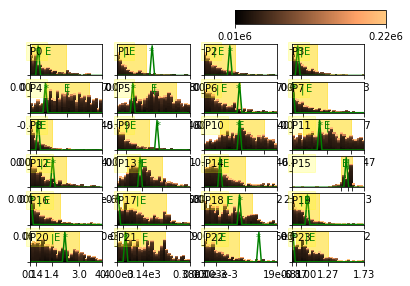

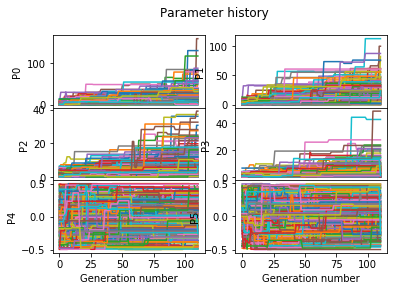

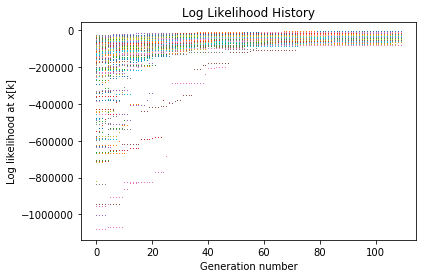

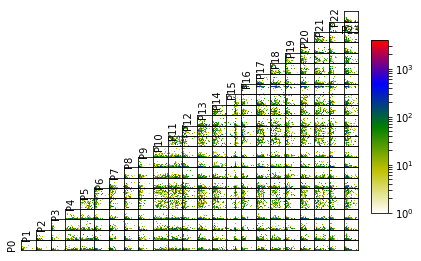

In [73]:
print("Number of parameters: %s" % state.Nvar)
state.show()

## Plot reflectivity from the model file
Update it using the best fit result

In [22]:
# Load the model used
code = open(file_path+'.py', 'r')
exec code

def _extract_reflectivity(_problem, model_id=0, name=''):
    plot_data = []
    data_names = []    
    if hasattr(problem, '_models'):
        _model = _problem._models[model_id]
    else:
        _model = _problem

    ref_data = _model.fitness.reflectivity()
    if not _model.fitness.ismagnetic:
        plot_data.append([ref_data[0], ref_data[1]])
        data_names.append(name)
    else:
        for i, _ref in enumerate(ref_data):
            if _ref is not None:
                plot_data.append([_ref[0], _ref[1]])
                data_names.append('%s %s' % (name, i+1))
    return plot_data, data_names

plot_data, data_names = _extract_reflectivity(problem, name='starting point')

# Update with the best fit result
best_pars, _ = state.best()
problem.setp(best_pars)

_plot_data, _data_names = _extract_reflectivity(problem, name='best')
plot_data.extend(_plot_data)
data_names.extend(_data_names)

plot_utils.plot1d(plot_data, data_names=data_names, y_log=True)

## Testing things out...

In [ ]:
# Load the model used
code = open(file_path+'.py', 'r')
exec code

pars = best_pars #pts[1160]
problem.setp(pars)

acc = Accumulator(z_max=600.0)

# Do something different if we did a simultaneous fit.
if hasattr(problem, '_models'):
    # This is a magnetic sample example
    z, r, _, rM, _ = problem._models[1].fitness.magnetic_smooth_profile()
    acc.add(z,r,rM)
else:
    # This is a non-magnetic sample example
    z, r, _ = problem.fitness.smooth_profile()
    acc.add(z,r,r)


_z, _sld, _dsld = acc.mean()
_z, _m_sld, _d_m_sld = acc.mean_magnetism()

plot_utils.plot1d([[_z, _sld, _dsld],
                   [_z, _m_sld, _d_m_sld],
                   [z, r]],
                    data_names = ['sld', 'm_sld', 'direct'])